# GoogleNet Implementation


- 2014 ILSVRC 1nd place 
- Inception Module

![대체 텍스트](https://cdn-images-1.medium.com/max/2560/1*ZFPOSAted10TPd3hBQU8iQ.png)

In [1]:
# 런타임 유형 GPU 모드로 변경
!pip install torch torchvision

  Using cached Pillow-8.4.0-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


## 1. Settings
### 1) Import required libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm.auto import trange

### 2) Hyperparameter

In [4]:
batch_size= 50
learning_rate = 0.0001
num_epoch = 100

## 2. Data Loader

In [5]:
img_dir = "../Data/images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      transforms.RandomResizedCrop(224),        
                                      transforms.RandomHorizontalFlip(),        
                                      transforms.ToTensor(),                    
            ]))


train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, drop_last=True, num_workers=2)

## 3. Model 
### 1) Base module

- 인셉션 모듈을 구성하는 4가지 연산을 함수로 정의해놓습니다.
- 1x1 컨볼루션
- 1x1 컨볼루션 -> 3x3 컨볼루션
- 1x1 컨볼루션 -> 5x5 컨볼루션
- 3x3 맥스풀링 ->1x1 컨볼루션

In [6]:
def conv_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model
    
def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model
    

def max_3_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(3,1,1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

### 2) Inception Module
- 앞서 정의한 연산으로 인셉션 모듈을 만듦니다.

In [13]:
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

### 3) GoogLeNet

![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*CWJGqfLiVjHAIan82nPbjg.png)

In [14]:
# 표와 비교하면서 볼 수 있도록 구현했습니다. 

class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), 
            nn.AvgPool2d(7,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

## 4. Optimizer & Loss

In [15]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

model = GoogLeNet(base_dim=64)
for i in model.named_children():
    print(i)

model = GoogLeNet(base_dim=64).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

cuda:1
('layer_1', Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
))
('layer_2', Sequential(
  (0): inception_module(
    (conv_1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (conv_1_3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_1_5): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
    (max_3_1): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, pad

## 5. Train

In [10]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6965, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6928, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6937, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6923, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6947, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6925, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6943, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6951, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6927, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6921, device='cuda:1', grad_fn=<NllLossBackward0>)



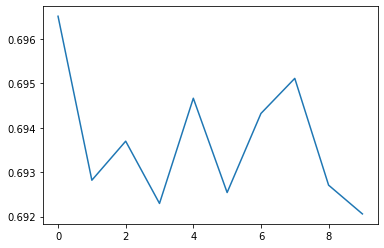

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()